# Fashion MNIST Classification

## Importing the Fashion MNIST Dataset

In [2]:
# import statements

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt

print(tf.__version__)

2.12.0-rc0


In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Exploring the Data

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
len(train_labels)

60000

In [6]:
test_images.shape

(10000, 28, 28)

In [7]:
len(test_images)

10000

## Preprocessing

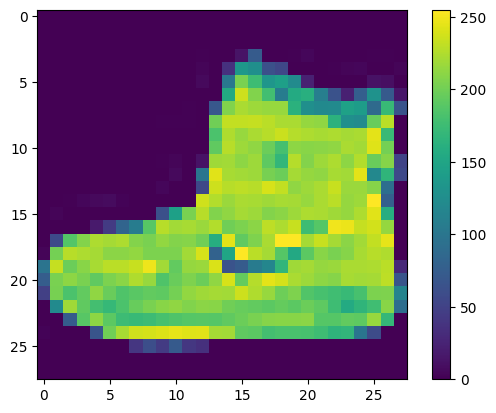

In [8]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [9]:
# Scaling all the values in the bitmap images to be between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

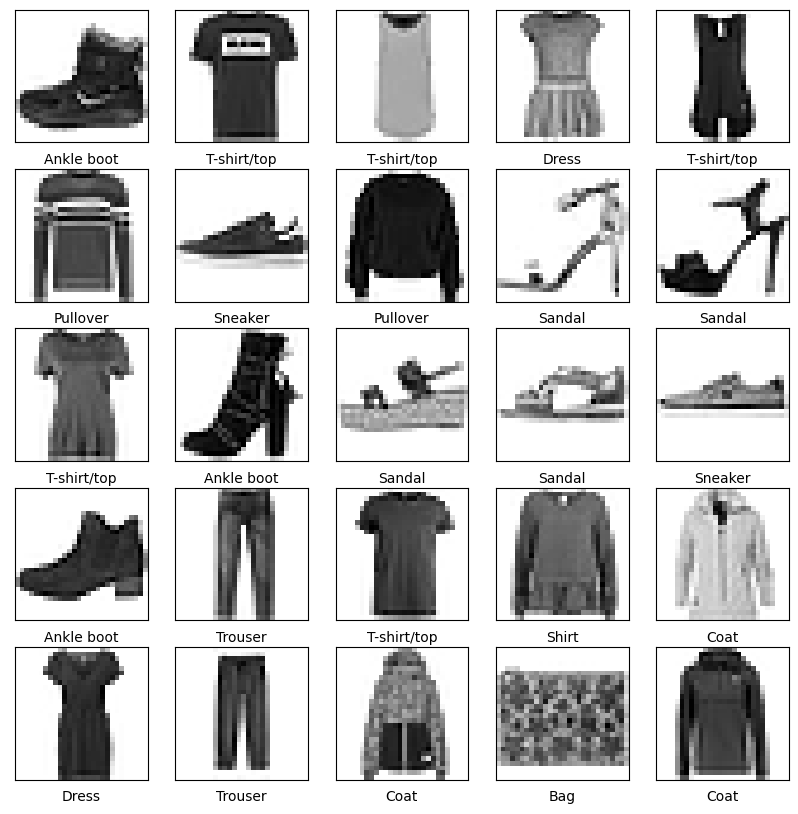

In [10]:
# Plotting 25 images and their label
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Creating the Model

### Defining the Model

In [11]:
def model_builder(hp):
    # Create the model
    model = tf.keras.Sequential()
    
    # Input Layer
    model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
    
    hp_units = [0] * 7

    # Tuning the number of nodes in the first layer
    for i in range(hp.Int("num_layers", 2, 6)):
        hp_units[i] = hp.Int("units_" + str(i), min_value=32, max_value=1024, step=64)
        #hp_reg_rate = hp.Choice("regularization_rate", values=[0.1])
        model.add(tf.keras.layers.Dense(units=hp_units[i], activation="relu"))
    
    hp_drop_rate = hp.Choice("dropout_rate", values=[0.2, 0.3, 0.4, 0.5])
    model.add(tf.keras.layers.Dropout(0.30))
    model.add(tf.keras.layers.Dense(10))    

    # Tune the learning rate from 0.01, 0.001, and 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    # Compiling the neural network
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

### Perform hypertuning

In [12]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='try3',
                     project_name='optimizingClothingClassification')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [13]:
tuner.search(train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[stop_early], batch_size=1200)

Trial 30 Complete [00h 00m 29s]
val_accuracy: 0.8884166479110718

Best val_accuracy So Far: 0.8929166793823242
Total elapsed time: 00h 07m 14s
INFO:tensorflow:Oracle triggered exit


In [14]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(best_hps.get("num_layers"))
print(best_hps.get("units_0"))
print(best_hps.get("units_1"))
print(best_hps.get("units_2"))
print(best_hps.get("learning_rate"))

2
544
672
416
0.001


### Train the Model

In [18]:
# Training the model
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_images, train_labels, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))


Epoch 1/50
1500/1500 [==============================] - 19s 12ms/step - loss: 0.5001 - accuracy: 0.8190 - val_loss: 0.4015 - val_accuracy: 0.8564
Epoch 2/50
1500/1500 [==============================] - 19s 13ms/step - loss: 0.3731 - accuracy: 0.8625 - val_loss: 0.3685 - val_accuracy: 0.8648
Epoch 3/50
1500/1500 [==============================] - 21s 14ms/step - loss: 0.3340 - accuracy: 0.8756 - val_loss: 0.3616 - val_accuracy: 0.8723
Epoch 4/50
1500/1500 [==============================] - 19s 13ms/step - loss: 0.3128 - accuracy: 0.8842 - val_loss: 0.3488 - val_accuracy: 0.8744
Epoch 5/50
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2951 - accuracy: 0.8902 - val_loss: 0.3330 - val_accuracy: 0.8802
Epoch 6/50
1500/1500 [==============================] - 19s 13ms/step - loss: 0.2788 - accuracy: 0.8950 - val_loss: 0.3406 - val_accuracy: 0.8833
Epoch 7/50
1500/1500 [==============================] - 23s 15ms/step - loss: 0.2658 - accuracy: 0.9008 - val_loss: 0.3578 -

In [19]:
# Retrain with best epoch
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain
hypermodel.fit(train_images, train_labels, epochs=best_epoch, validation_split=0.2)

Epoch 1/43
1500/1500 [==============================] - 20s 13ms/step - loss: 0.4984 - accuracy: 0.8183 - val_loss: 0.3996 - val_accuracy: 0.8529
Epoch 2/43
1500/1500 [==============================] - 17s 11ms/step - loss: 0.3718 - accuracy: 0.8642 - val_loss: 0.3765 - val_accuracy: 0.8612
Epoch 3/43
1500/1500 [==============================] - 19s 12ms/step - loss: 0.3384 - accuracy: 0.8753 - val_loss: 0.3612 - val_accuracy: 0.8757
Epoch 4/43
1500/1500 [==============================] - 19s 12ms/step - loss: 0.3156 - accuracy: 0.8833 - val_loss: 0.3539 - val_accuracy: 0.8794
Epoch 5/43
1500/1500 [==============================] - 17s 11ms/step - loss: 0.2974 - accuracy: 0.8897 - val_loss: 0.3619 - val_accuracy: 0.8756
Epoch 6/43
1500/1500 [==============================] - 17s 11ms/step - loss: 0.2807 - accuracy: 0.8954 - val_loss: 0.3341 - val_accuracy: 0.8875
Epoch 7/43
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2658 - accuracy: 0.8999 - val_loss: 0.3172 -

In [20]:
# Accuracy on Test Set
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print("\nTest accuracy:", test_acc)

313/313 - 1s - loss: 0.7864 - accuracy: 0.8870 - 1s/epoch - 4ms/step

Test accuracy: 0.8870000243186951


In [21]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model(test_images)
predictions[0]
np.argmax(predictions[0])


9

In [22]:
test_labels[0]

9

In [23]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
    100*np.max(predictions_array), class_names[true_label]),color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color("red")
    thisplot[true_label].set_color("blue")


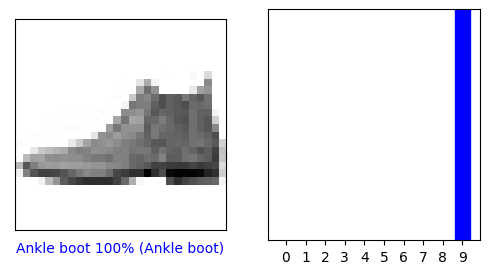

In [24]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], test_labels)
plt.show()

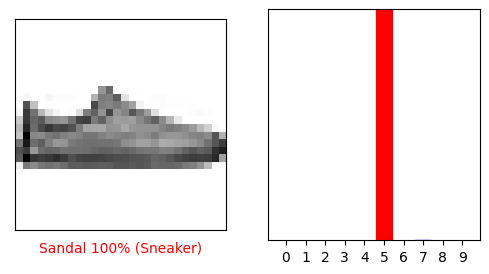

In [25]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], test_labels)
plt.show()

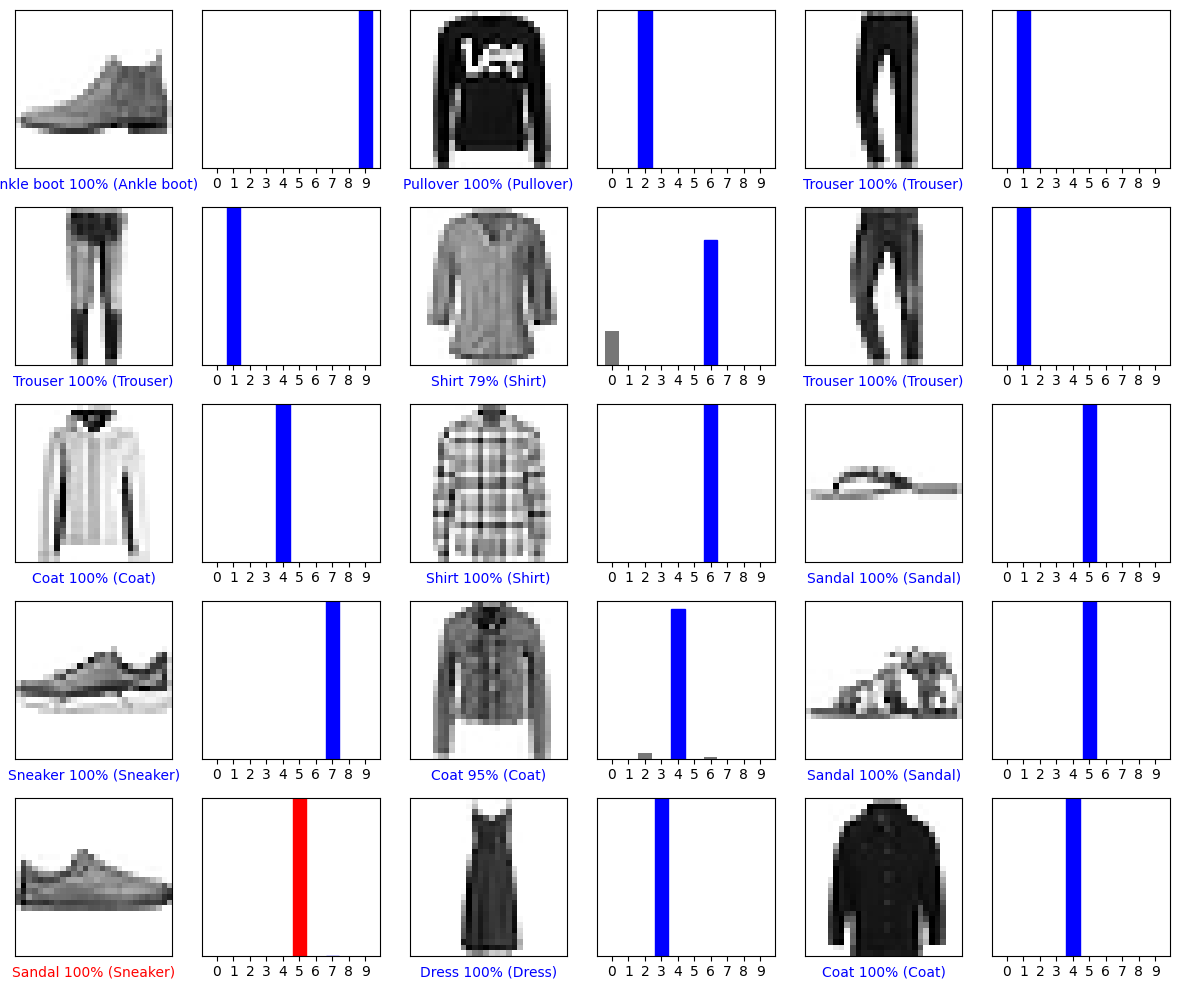

In [26]:
# Visualization of the results
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

(28, 28)
(1, 28, 28)
1/1 [==============================] - 0s 161ms/step
[[2.40357179e-17 1.42993045e-34 1.00000000e+00 1.87586154e-27
  1.02900355e-08 1.89247645e-37 3.63425991e-11 0.00000000e+00
  8.22009550e-24 0.00000000e+00]]


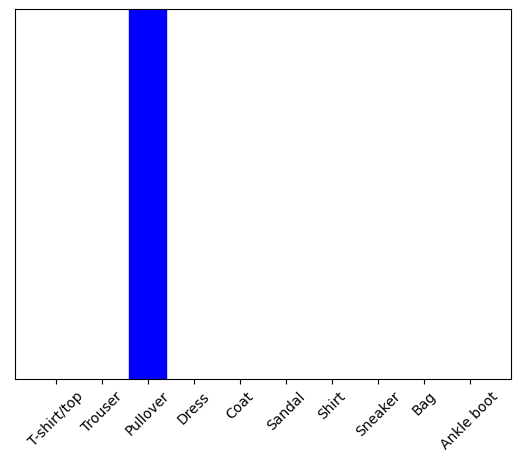

Pullover


In [27]:
# Testing on a single image
img = test_images[1]
print(img.shape)
img = np.expand_dims(img,0)
print(img.shape)

predictions_single = probability_model.predict(img)
print(predictions_single)
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()
print(class_names[np.argmax(predictions_single[0])])